In [1]:
import torch 
import torch.nn as nn
import torch.functional as F

In [2]:
logits, sequences = torch.load('all_logits(01).pt'), torch.load('all_sequences(01).pt')

C:\Users\Bagas\AppData\Local\Temp\ipykernel_3228\890874327.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  logits, sequences = torch.load('all_logits(01).pt'), torch.loa

In [13]:
logits.dtype

torch.float32

In [14]:
logits.shape

torch.Size([28, 16, 32015])

In [15]:
logit = logits[:4]
logit.shape

torch.Size([4, 16, 32015])

In [16]:
logit.shape

torch.Size([4, 16, 32015])

In [18]:
torch.save(logit, "logits.pt")

C:\Users\Bagas\AppData\Local\Temp\ipykernel_3228\1394898662.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  logits = torch.load('logits.pt', map_location='cpu')


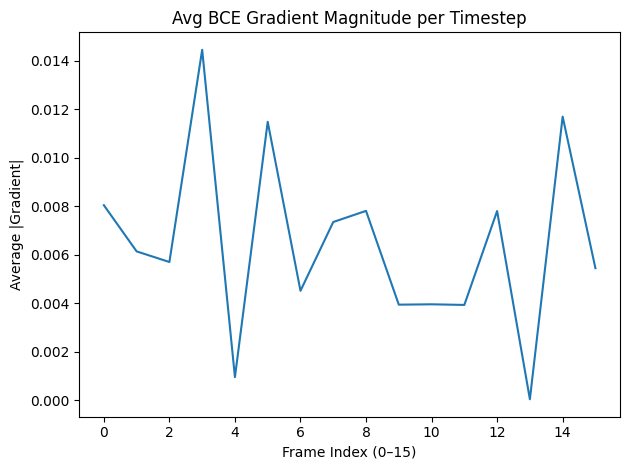

In [19]:
import torch
import matplotlib.pyplot as plt

# 1. Load your logits file (shape: 4×16×32015)
logits = torch.load('logits.pt', map_location='cpu')  
assert logits.shape == (4, 16, 32015), f"Expected (4,16,32015), got {logits.shape}"

# 2. Extract the two “binary” logits:
ID_ZERO = 29900
ID_ONE  = 29896
logits_zero = logits[:, :, ID_ZERO]     # score for token “0”
logits_one  = logits[:, :, ID_ONE]      # score for token “1”

# 3. Form a single “positive” logit (you can also use just logits_one if you prefer)
logit_pos = (logits_one - logits_zero).clone().detach().requires_grad_(True)  # [4×16]

# 4. Create some dummy binary targets (replace with your real labels!)
targets = torch.randint(0, 2, (4, 16)).float()  # random 0/1

# 5. Compute BCEWithLogitsLoss
bce = torch.nn.BCEWithLogitsLoss(reduction='mean')
loss = bce(logit_pos, targets)

# 6. Backpropagate and grab the gradients w.r.t. logit_pos
loss.backward()
grad = logit_pos.grad  # [4×16]

# 7. Average |gradient| across the batch, per timestep
avg_grad = grad.abs().mean(dim=0).cpu().numpy()  # length 16

# 8. Plot
plt.figure()
plt.plot(range(16), avg_grad)
plt.xlabel('Frame Index (0–15)')
plt.ylabel('Average |Gradient|')
plt.title('Avg BCE Gradient Magnitude per Timestep')
plt.tight_layout()
plt.show()


In [33]:
import torch
import torch.nn.functional as F

# Load logits and extract shape
logits = torch.load('logits.pt')  # shape: [4, 16, 32015]
ID_ZERO = 29900
ID_ONE  = 29896

# We'll just work with the first example in the batch
logits_sample = logits[0, :15].requires_grad_(True)  # shape: [15, 32015]

# Extract only logits for token "1" and "0"
logits_0 = logits_sample[:, ID_ZERO]  # [15]
logits_1 = logits_sample[:, ID_ONE]   # [15]

# Form a single score: logit for class 1 vs 0
logit_pos = (logits_1 - logits_0)  # [15]

# Ground truth label: convert string to float tensor
label_str = "111000000000000"
targets = torch.tensor([float(c) for c in label_str])  # shape: [15]

print(targets)


tensor([1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


C:\Users\Bagas\AppData\Local\Temp\ipykernel_3228\1143975991.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  logits = torch.load('logits.pt')  # shape: [4, 16, 32015]


In [35]:
logit_pos

tensor([-0.3750, -0.5000, -1.8750, -2.7500, -2.8750, -3.3750, -2.7500,  1.8750,
         4.0000,  4.6875,  4.9375,  5.6875,  5.2500,  5.9375,  6.0000],
       grad_fn=<SubBackward0>)

In [29]:
logits_sample.shape

torch.Size([15, 32015])

In [30]:
# Compute BCE loss
loss = F.binary_cross_entropy_with_logits(logit_pos, targets)
print("Loss:", loss.item())

Loss: 2.8445465564727783


In [31]:
logit_pos

tensor([-0.3750, -0.5000, -1.8750, -2.7500, -2.8750, -3.3750, -2.7500,  1.8750,
         4.0000,  4.6875,  4.9375,  5.6875,  5.2500,  5.9375,  6.0000])

In [32]:
targets

tensor([1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])